*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Spike-timing Dependent Plasticity (STDP)

_**Motivation**: In this tutorial, we will demonstrate usage of a software model of Loihi's learning engine, exposed in Lava. This involves the LearningRule object for learning rule and other learning-related information encapsulation and the LearningDense Lava Process modelling learning-enabled connections._

#### This tutorial assumes that you:
- have the [Lava framework installed](../../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- are familiar with the [ProcessModel concept in Lava](../../in_depth/tutorial02_process_models.ipynb "Tutorial on ProcessModels")
- are familiar with how to [connect Lava Processes](../../in_depth/tutorial05_connect_processes.ipynb "Tutorial on connecting Processes")

This tutorial gives a bird's-eye view of how to make use of the available learning rules in Lavas Process Library. For this purpose, we will create a network of LIF and Dense processes with one plastic connection and generate frozen patterns of activity. We can easily choose between a floating point simulation of the learning engine and a fixed point simulation, which approximates the behavior on the Loihi neuromorphic hardware. We also will create monitors to observe the behavior of the weights and activity traces of the neurons and learning rules.

## STDP from Lavas Process Library

Let's first generate the random, frozen input and define all parameters for the network.

### Parameters

In [1]:
import numpy as np

# Set this tag to "fixed_pt" or "floating_pt" to choose the corresponding models.
SELECT_TAG = "floating_pt"

# LIF parameters
if SELECT_TAG == "fixed_pt":
    du = 4095
    dv = 4095
elif SELECT_TAG == "floating_pt":
    du = 1
    dv = 1
vth = 240

# Number of neurons per layer
num_neurons = 1
shape_lif = (num_neurons, )
shape_conn = (num_neurons, num_neurons)

# Connection parameters

# SpikePattern -> LIF connection weight
wgt_inp = np.eye(num_neurons) * 250

# LIF -> LIF connection initial weight (learning-enabled)
wgt_plast_conn = np.full(shape_conn, 50)
    
# Number of simulation time steps
num_steps = 200
time = list(range(1, num_steps + 1))

# Spike times
spike_prob = 0.03

# Create spike rasters
np.random.seed(123)
spike_raster_pre = np.zeros((num_neurons, num_steps))
np.place(spike_raster_pre, np.random.rand(num_neurons, num_steps) < spike_prob, 1)

spike_raster_post = np.zeros((num_neurons, num_steps))
np.place(spike_raster_post, np.random.rand(num_neurons, num_steps) < spike_prob, 1)

### Define STDP learning rule

Next, lets instatiate the STDP learning rule from the Lava Process Library. The STDPLoihi learning rule provides the parameters as described in Gerstner and al. 1996 (see also http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity).

In [2]:
from lava.proc.learning_rules.stdp_learning_rule import STDPLoihi

In [3]:
stdp = STDPLoihi(learning_rate=1,
                 A_plus=-1,
                 A_minus=1,
                 tau_plus=10,
                 tau_minus=10,
                 t_epoch=4)

### Create Network
The following diagram depics the Lava Process architecture used in this tutorial. It consists of:
- 2 Constant pattern generators for injection spike trains to LIF neurons.
- 2 _LIF_ Processes representing pre- and post-synaptic Leaky Integrate-and-Fire neurons.
- 1 _Dense_ Process representing learning-enable connection between LIF neurons.

>**Note:** 
All neuronal population (spike generator, LIF) are composed of only 1 neuron in this tutorial.

<img src="https://raw.githubusercontent.com/lava-nc/lava-docs/main/_static/images/tutorial_learning/learning_tutorial_architecture.svg" alt="Architecture.svg" style="width: 70%;"/>

#### The plastic connection Process
We now instantiate our plastic Dense process. The Dense Process provides the following Vars and Ports relevant for plasticity:

| Component | Name | Description |
| :- | :- | :- |
| **InPort** | `s_in_bap` | Receives spikes from post-synaptic neurons.
| **Var** | `tag_2` | Delay synaptic variable.
|         | `tag_1` | Tag synaptic variable.
|         | `x0` | State of $x_0$ dependency.
|         | `tx` | Within-epoch spike times of pre-synaptic neurons.
|         | `x1` | State of $x_1$ trace.
|         | `x2` | State of $x_2$ trace.
|         | `y0` | State of $y_0$ dependency.
|         | `ty` | Within-epoch spike times of post-synaptic neurons.
|         | `y1` | State of $y_1$ trace.
|         | `y2` | State of $y_2$ trace.
|         | `y3` | State of $y_3$ trace.



In [4]:
from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer
from lava.proc.dense.process import LearningDense, Dense

In [5]:
# Create input devices
pattern_pre = RingBuffer(data=spike_raster_pre.astype(int))
pattern_post = RingBuffer(data=spike_raster_post.astype(int))

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_inp)
conn_inp_post = Dense(weights=wgt_inp)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du,
              dv=du,
              bias_mant=0,
              bias_exp=0,
              vth=vth,
              shape=shape_lif,
              name='lif_pre')

# Create plastic connection
plast_conn = LearningDense(weights=wgt_plast_conn,
                           learning_rule=stdp,
                           name='plastic_dense')

# Create post-synaptic neuron
lif_post = LIF(u=0,
               v=0,
               du=du,
               dv=du,
               bias_mant=0,
               bias_exp=0,
               vth=vth,
               shape=shape_lif,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

pattern_post.s_out.connect(conn_inp_post.s_in)
conn_inp_post.a_out.connect(lif_post.a_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating actionpotential (BAP)
lif_post.s_out.connect(plast_conn.s_in_bap)

### Create monitors to observe traces

In [6]:
from lava.proc.monitor.process import Monitor

In [7]:
# Create monitors
mon_pre_trace = Monitor()
mon_post_trace = Monitor()
mon_pre_spikes = Monitor()
mon_post_spikes = Monitor()
mon_weight = Monitor()

# Connect monitors
mon_pre_trace.probe(plast_conn.x1, num_steps)
mon_post_trace.probe(plast_conn.y1, num_steps)
mon_pre_spikes.probe(lif_pre.s_out, num_steps)
mon_post_spikes.probe(lif_post.s_out, num_steps)
mon_weight.probe(plast_conn.weights, num_steps)

### Running

In [8]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

In [9]:
# Running
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))

In [10]:
# Get data from monitors
pre_trace = mon_pre_trace.get_data()['plastic_dense']['x1']
post_trace = mon_post_trace.get_data()['plastic_dense']['y1']
pre_spikes = mon_pre_spikes.get_data()['lif_pre']['s_out']
post_spikes = mon_post_spikes.get_data()['lif_post']['s_out']
weights = mon_weight.get_data()['plastic_dense']['weights'][:, :, 0]

In [11]:
# Stopping
pattern_pre.stop()

### Results

Now, we can take a look at the results of the simulation. 

In [12]:
import matplotlib.pyplot as plt

#### Plot spike trains

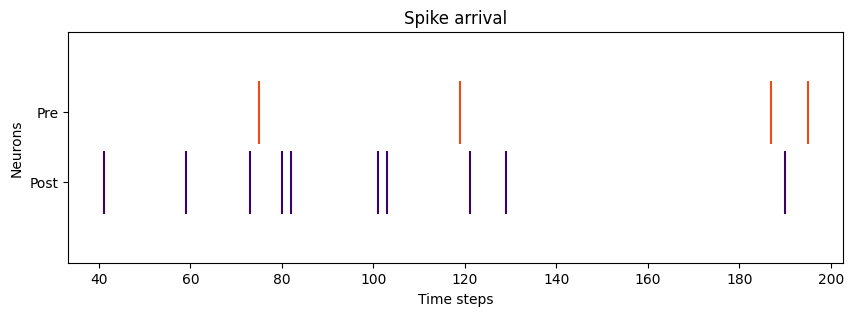

In [13]:
# Plotting pre- and post- spike arrival
def plot_spikes(spikes, legend, colors):
    offsets = list(range(1, len(spikes) + 1))
    
    plt.figure(figsize=(10, 3))
    
    spikes_plot = plt.eventplot(positions=spikes, 
                                lineoffsets=offsets,
                                linelength=0.9,
                                colors=colors)
    
    plt.title("Spike arrival")
    plt.xlabel("Time steps")
    plt.ylabel("Neurons")
    plt.yticks(ticks=offsets, labels=legend)
    
    plt.show()

# Plot spikes
plot_spikes(spikes=[np.where(post_spikes[:, 0])[0], np.where(pre_spikes[:, 0])[0]], 
            legend=['Post', 'Pre'], 
            colors=['#370665', '#f14a16'])

#### Plot traces

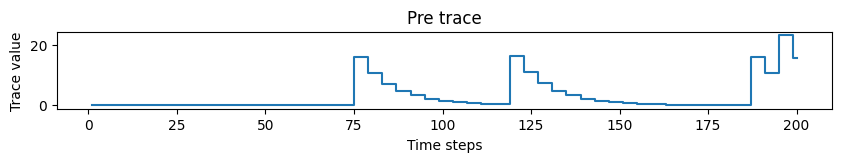

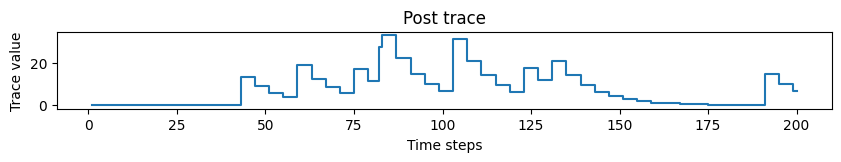

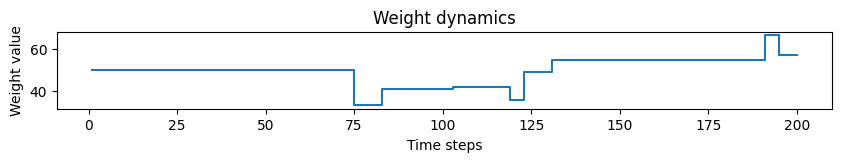

In [14]:
# Plotting trace dynamics
    
def plot_time_series(time, time_series, ylabel, title):
    plt.figure(figsize=(10, 1))
    
    plt.step(time, time_series)
    
    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)
    
    plt.show()
    
# Plotting pre trace dynamics
plot_time_series(time=time, time_series=pre_trace, ylabel="Trace value", title="Pre trace")
# Plotting post trace dynamics
plot_time_series(time=time, time_series=post_trace, ylabel="Trace value", title="Post trace")
# Plotting weight dynamics
plot_time_series(time=time, time_series=weights, ylabel="Weight value", title="Weight dynamics")

#### Plot STDP learning window and weight changes

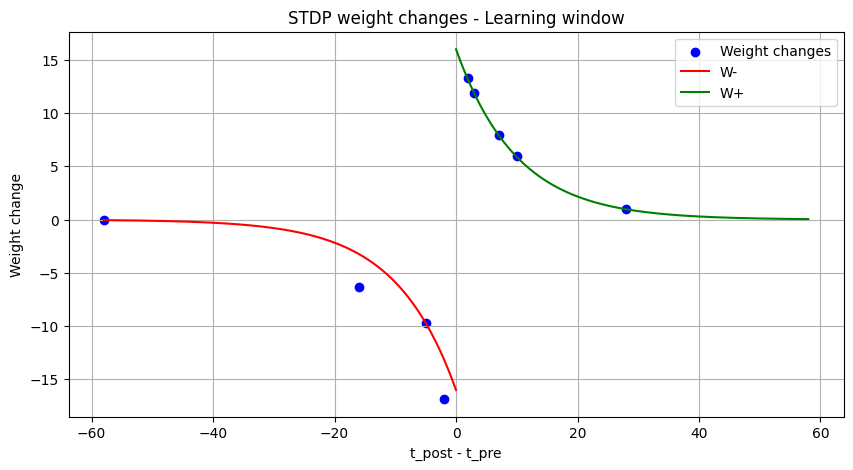

In [15]:
def extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt):
    # Compute the weight changes for every weight change event
    w_diff = np.zeros(wgt.shape)
    w_diff[1:] = np.diff(wgt)

    w_diff_non_zero = np.where(w_diff != 0)
    dw = w_diff[w_diff_non_zero].tolist()

    # Find the absolute time of every weight change event
    time = np.array(time)
    t_non_zero = time[w_diff_non_zero]

    # Compute the difference between post and pre synaptic spike time for every weight change event
    spikes_pre = np.array(spikes_pre)
    spikes_post = np.array(spikes_post)
    dt = []
    for i in range(0, len(dw)):
        time_stamp = t_non_zero[i]
        t_post = (spikes_post[np.where(spikes_post <= time_stamp)])[-1]
        t_pre = (spikes_pre[np.where(spikes_pre <= time_stamp)])[-1]
        dt.append(t_post-t_pre)

    return np.array(dt), np.array(dw)
    
def plot_stdp(time, spikes_pre, spikes_post, wgt, 
              on_pre_stdp, y1_impulse, y1_tau, 
              on_post_stdp, x1_impulse, x1_tau):
    # Derive weight changes as a function of time differences
    diff_t, diff_w = extract_stdp_weight_changes(time, spikes_pre, spikes_post, wgt)
    
    # Derive learning rule coefficients
    on_pre_stdp = eval(str(on_pre_stdp).replace("^", "**"))
    a_neg = on_pre_stdp * y1_impulse
    on_post_stdp = eval(str(on_post_stdp).replace("^", "**"))
    a_pos = on_post_stdp * x1_impulse
    
    # Derive x-axis limit (absolute value)
    max_abs_dt = np.maximum(np.abs(np.max(diff_t)), np.abs(np.min(diff_t)))
    
    # Derive x-axis for learning window computation (negative part)
    x_neg = np.linspace(-max_abs_dt, 0, 1000)
    # Derive learning window (negative part)
    w_neg = a_neg * np.exp(x_neg / y1_tau)
    
    # Derive x-axis for learning window computation (positive part)
    x_pos = np.linspace(0, max_abs_dt, 1000)
    # Derive learning window (positive part)
    w_pos = a_pos * np.exp(- x_pos / x1_tau)
    
    plt.figure(figsize=(10, 5))
    
    plt.scatter(diff_t, diff_w, label="Weight changes", color="b")
    
    plt.plot(x_neg, w_neg, label="W-", color="r")
    plt.plot(x_pos, w_pos, label="W+", color="g")
    
    plt.title("STDP weight changes - Learning window")
    plt.xlabel('t_post - t_pre')
    plt.ylabel('Weight change')
    plt.legend()
    plt.grid()
    
    plt.show()

# Plot STDP window
plot_stdp(time, np.where(pre_spikes[:, 0]), np.where(post_spikes[:, 0]), weights[:, 0], 
          stdp.A_plus, stdp.y1_impulse, stdp.tau_plus, 
          stdp.A_minus, stdp.x1_impulse, stdp.tau_minus)

As can be seen, the actual weight changes follow the defined STDP with a certain amout of noise. If the tag is set to `fixed_pt`, the weight changes get more quantized, but still follow the correct trend.